In [1]:
# Healthcare Fraud Detection Project
# Covers: Descriptive, Predictive, and Prescriptive Triggers with Visualizations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
# ------------------ Step 1: Load Mock Data ------------------
# Simulated PMJAY claims data
data = pd.DataFrame({
    'claim_id': range(1, 101),
    'hospital_id': np.random.choice(['H001', 'H002', 'H003'], 100),
    'patient_id': np.random.randint(1000, 1100, 100),
    'admission_date': pd.date_range('2023-01-01', periods=100, freq='D'),
    'claim_amount': np.random.normal(20000, 5000, 100).round(2),
    'procedure_code': np.random.choice(['PROC_A', 'PROC_B', 'PROC_C'], 100),
    'distance_to_hospital_km': np.random.uniform(1, 100, 100),
    'fraud_label': np.random.choice([0, 1], 100, p=[0.85, 0.15])  # 0 = Legit, 1 = Fraud
    })

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   claim_id                 100 non-null    int64         
 1   hospital_id              100 non-null    object        
 2   patient_id               100 non-null    int32         
 3   admission_date           100 non-null    datetime64[ns]
 4   claim_amount             100 non-null    float64       
 5   procedure_code           100 non-null    object        
 6   distance_to_hospital_km  100 non-null    float64       
 7   fraud_label              100 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(2), object(2)
memory usage: 6.0+ KB


In [3]:
# ------------------ Step 2: Descriptive Triggers ------------------
# Rule 1: High number of claims in a single day by same hospital
rule1 = data.groupby(['hospital_id', 'admission_date']).size().reset_index(name='claim_count')
descriptive_alerts = rule1[rule1['claim_count'] > 3]  # Threshold set to 3

# Rule 2: High claim amount
rule2_alerts = data[data['claim_amount'] > 40000]  # Static threshold

# Combine descriptive alerts
print("\nDescriptive Alerts:")
print(pd.concat([descriptive_alerts, rule2_alerts[['claim_id', 'claim_amount']]], axis=0, ignore_index=True))




Descriptive Alerts:
Empty DataFrame
Columns: [hospital_id, admission_date, claim_count, claim_id, claim_amount]
Index: []



Predictive Model Performance:
[[19  0]
 [ 1  0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.00      0.00      0.00         1

    accuracy                           0.95        20
   macro avg       0.47      0.50      0.49        20
weighted avg       0.90      0.95      0.93        20

ROC AUC Score: 0.7894736842105263


c:\Users\amans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\amans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\amans\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

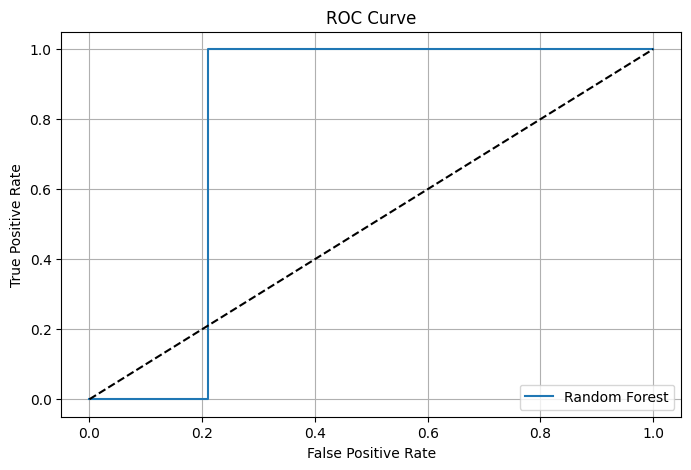

In [4]:
# ------------------ Step 3: Predictive Modeling ------------------
# Feature Engineering
features = data[['claim_amount', 'distance_to_hospital_km']]
labels = data['fraud_label']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
pred_probs = model.predict_proba(X_test)[:, 1]

print("\nPredictive Model Performance:")
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print("ROC AUC Score:", roc_auc_score(y_test, pred_probs))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, pred_probs)
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Add fraud risk score to full dataset
risk_scores = model.predict_proba(features)[:, 1]
data['fraud_risk_score'] = risk_scores

In [5]:
# ------------------ Step 4: Prescriptive Prioritization ------------------
# Create a priority score = fraud risk × claim amount
data['priority_score'] = data['fraud_risk_score'] * data['claim_amount']

# Assume limited capacity: investigate top 10 only
top_cases = data.sort_values('priority_score', ascending=False).head(10)

print("\nTop 10 Prescriptive Priority Cases:")
print(top_cases[['claim_id', 'fraud_risk_score', 'claim_amount', 'priority_score']])


Top 10 Prescriptive Priority Cases:
    claim_id  fraud_risk_score  claim_amount  priority_score
78        79              0.67      30304.94      20304.3098
86        87              0.62      28146.16      17450.6192
68        69              0.63      27137.95      17096.9085
50        51              0.67      25442.59      17046.5353
42        43              0.66      25226.33      16649.3778
85        86              0.64      18929.36      12114.7904
15        16              0.60      19215.54      11529.3240
64        65              0.71      15605.49      11079.8979
52        53              0.62      16996.92      10538.0904
33        34              0.37      27359.87      10123.1519


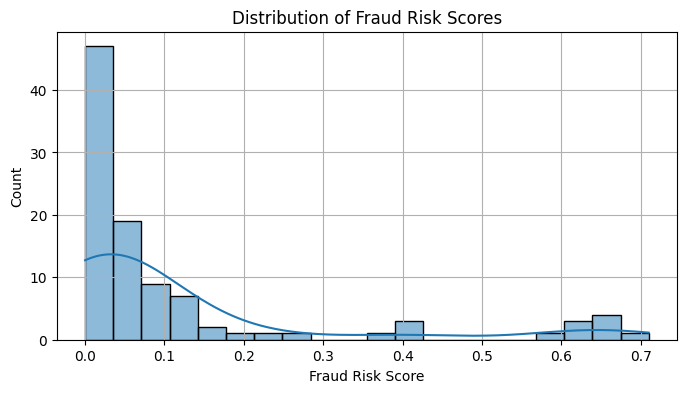

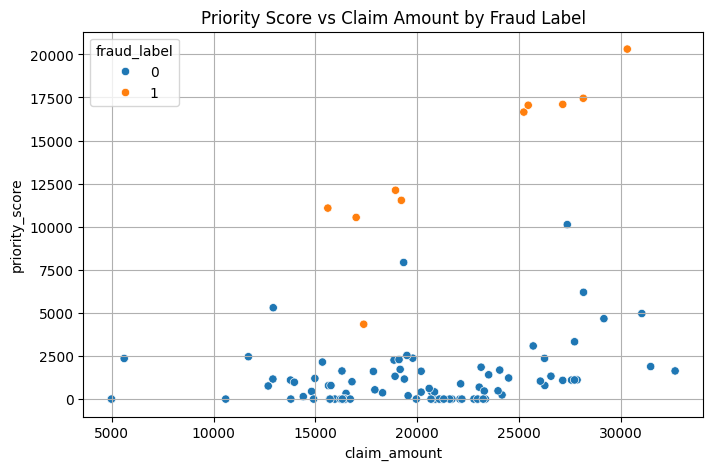

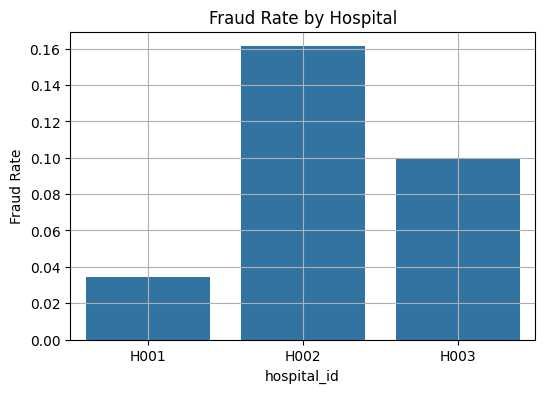

In [6]:
# ------------------ Step 5: Visualization ------------------
# Fraud Risk Distribution
plt.figure(figsize=(8, 4))
sns.histplot(data['fraud_risk_score'], bins=20, kde=True)
plt.title('Distribution of Fraud Risk Scores')
plt.xlabel('Fraud Risk Score')
plt.grid(True)
plt.show()

# Priority Score vs Claim Amount
plt.figure(figsize=(8, 5))
sns.scatterplot(data=data, x='claim_amount', y='priority_score', hue='fraud_label')
plt.title('Priority Score vs Claim Amount by Fraud Label')
plt.grid(True)
plt.show()

# Fraud Rate by Hospital
fraud_rate = data.groupby('hospital_id')['fraud_label'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(data=fraud_rate, x='hospital_id', y='fraud_label')
plt.title('Fraud Rate by Hospital')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.show()


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   claim_id                 100 non-null    int64         
 1   hospital_id              100 non-null    object        
 2   patient_id               100 non-null    int32         
 3   admission_date           100 non-null    datetime64[ns]
 4   claim_amount             100 non-null    float64       
 5   procedure_code           100 non-null    object        
 6   distance_to_hospital_km  100 non-null    float64       
 7   fraud_label              100 non-null    int64         
 8   fraud_risk_score         100 non-null    float64       
 9   priority_score           100 non-null    float64       
dtypes: datetime64[ns](1), float64(4), int32(1), int64(2), object(2)
memory usage: 7.6+ KB


In [ ]:

import plotly.express as px

# Create box plot
fig = px.box(data, x='hospital_id', y='claim_amount', color='fraud_risk_score', title='Transaction Amount Distribution by Merchant and Fraud Status', color_discrete_map={'Fraud': 'red', 'Non-Fraud': 'blue'})

# Update layout
fig.update_layout(
    xaxis_title="hospital_id",
    yaxis_title="claim_amount",
    showlegend=True,
    xaxis_tickangle=45,
    plot_bgcolor='white'
)

fig.show()

Note: you may need to restart the kernel to use updated packages.
